c:\Users\Dell\anaconda3\envs\dl_kerasocr\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


You must install pydot (`pip install pydot`) for `plot_model` to work.
Model plot saved as cnn_model.png


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Load Pretrained Model Weights (if available)
try:
    base_model = tf.keras.models.load_model('finalDataModel.keras')
    print("✅ Loaded existing model weights!")
except:
    print("⚠️ No pre-trained model found, training from scratch.")
    base_model = None

# Define an Improved Model
model = Sequential()

# 1st Convolutional Block
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(75,75,3), kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())  
model.add(MaxPooling2D(pool_size=(2,2)))

# 2nd Convolutional Block
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# 3rd Convolutional Block (Reduce filters to prevent overfitting)
model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Feature Extraction
model.add(GlobalAveragePooling2D())

# Fully Connected Layers
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.6))  # Increased dropout to prevent overfitting
model.add(Dense(4, activation='softmax'))  # 4 Output Classes

# Compile Model with Adam & Focal Loss
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

# Summary
model.summary()


✅ Loaded existing model weights!


c:\Users\Dell\anaconda3\envs\dl_kerasocr\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 73, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 639,876 (2.44 MB)

 Trainable params: 638,980 (2.44 MB)

 Non-trainable params: 896 (3.50 KB)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define Augmentation for Training Data
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],  
    shear_range=0.2,  
    validation_split=0.2  # 80% Train, 20% Validation
)

# Path to Your Dataset Folder (Same for Train & Validation)
dataset_path = "data/finalData"

# Train Generator (80% of data)
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(75, 75),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Splitting as Training Data
)

# Validation Generator (20% of data)
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(75, 75),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Splitting as Validation Data
)


Found 20000 images belonging to 4 classes.
Found 5000 images belonging to 4 classes.


In [5]:
# Handling Class Imbalance
from sklearn.utils import class_weight
import numpy as np

# Assuming train_data.class_indices is available
class_labels = list(train_generator.class_indices.keys())
class_counts = np.array([1875, 1500, 1375, 1500])  # Update with real dataset distribution
total_samples = np.sum(class_counts)

# Compute Class Weights
class_weights = {i: total_samples/class_counts[i] for i in range(len(class_counts))}

# Train Model with Class Weights
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    class_weight=class_weights  # Balance misclassified classes
)


c:\Users\Dell\anaconda3\envs\dl_kerasocr\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 628s 998ms/step - accuracy: 0.7776 - loss: 3.7763 - val_accuracy: 0.9150 - val_loss: 1.1360
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 464s 741ms/step - accuracy: 0.9144 - loss: 2.7030 - val_accuracy: 0.8020 - val_loss: 1.2993
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 398s 637ms/step - accuracy: 0.9300 - loss: 2.5035 - val_accuracy: 0.9270 - val_loss: 0.9547
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 388s 621ms/step - accuracy: 0.9404 - loss: 2.3629 - val_accuracy: 0.9534 - val_loss: 0.8442
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 374s 598ms/step - accuracy: 0.9485 - loss: 2.2147 - val_accuracy: 0.6300 - val_loss: 1.6047
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 374s 598ms/step - accuracy: 0.9557 - loss: 2.1221 - val_accuracy: 0.9196 - val_loss: 0.7896
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 372s 594ms/step - accuracy: 0.9603 - loss: 2.0252 - val_accuracy: 0.8240 - val_loss: 0.9047
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 377s 603ms/step - accuracy: 0.9627 -

In [ ]:
# model save?

157/157 ━━━━━━━━━━━━━━━━━━━━ 30s 190ms/step
🔍 Classification Report:
              precision    recall  f1-score   support

 agriculture       0.29      0.29      0.29      1500
      forest       0.23      0.23      0.23      1200
       urban       0.23      0.23      0.23      1100
       water       0.23      0.23      0.23      1200

    accuracy                           0.25      5000
   macro avg       0.25      0.25      0.25      5000
weighted avg       0.25      0.25      0.25      5000



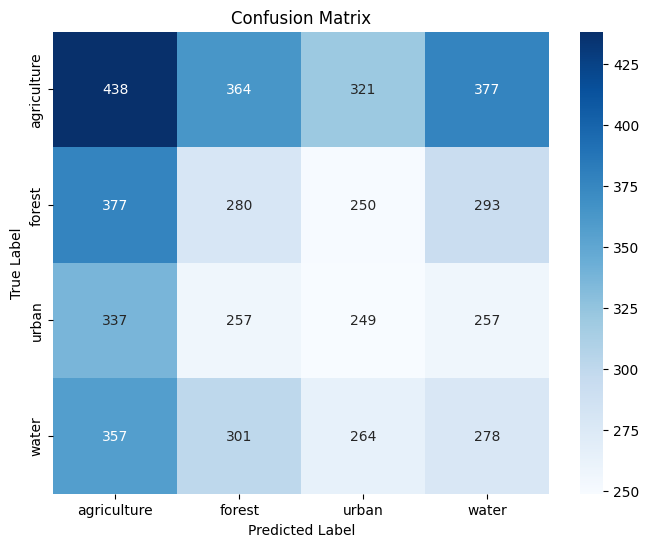

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load Trained Model
# model = load_model('finalDataModel.keras')

# Define Class Labels
class_labels = list(train_generator.class_indices.keys())  # Same order as training

# Get Predictions on Validation Set
y_true = val_generator.classes  # Actual class labels
y_pred_prob = model.predict(val_generator)  # Get class probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert to class indices

# Classification Report
print("🔍 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
